In [1]:
import numpy as np
import math
import sys
import json
import pandas as pd
import time
import matplotlib.pyplot as plt
import random
import itertools

In [2]:
#Simulation Variables
officer_max_rec=20
officer_min_rec=0
sailor_max_rec=25
sailor_min_rec=0

In [3]:
#Optimisation Variables
# Number of cycles
num_cycles = 75
# Number of trials per cycle
num_trials = 75
# Number of accepted solutions
na = 0.0
# Probability of accepting worse solution at the start
p1 = 0.7
# Probability of accepting worse solution at the end
p50 = 0.001
#number of repetitions per policy
num_rep=50


In [4]:
from javaconnector import KronosModelConnector

kronos = KronosModelConnector()

In [5]:
def dataset2list(dataSet):
    List=[]
    for idx in range(0, dataSet.size()):
        List.append(dataSet.getY(idx))
    return List

In [6]:
#Generate Recruitment Policy
def generateRec(kronos,officer_min_rec,officer_max_rec,sailor_min_rec,sailor_max_rec):
    dirFile= "conf/Model-Config_ZA_TP2.xlsx"
    kronos.load_config(dirFile)
    num_quarters= kronos.conf.sim_length_months/3
    a=np.random.randint(officer_min_rec,officer_max_rec+1,int(num_quarters))
    b=np.random.randint(sailor_min_rec,sailor_max_rec+1,int(num_quarters))
    rec_policy=[a,b]
    return rec_policy

In [7]:
#Input all variables into workforce model and output results
def policyOut(kronos,rec_policy,loss_numH, loss_numL):
    dirFile= "conf/Model-Config_ZA_TP2.xlsx"
    kronos.load_config(dirFile)
    num_quarters= kronos.conf.sim_length_months/3
    
    kronos.conf.clear_input_rate_schedules()
    
    uncert(kronos,loss_numH,loss_numL)



    for i in range(0, int(num_quarters)):
        kronos.conf.add_input_rate_schedule(i, "Sailor", rec_policy[1][i] )
        kronos.conf.add_input_rate_schedule(i, "Officer",rec_policy[0][i] )
    
    kronos.init_model()
    kronos.conf.set_slot_mode("ZERO_AVAILABLILTY")
 
    kronos.main.write_output = False;

    kronos.run_model()
    
    sailors = kronos.main.get_workforce( "Sailor" )
    officers = kronos.main.get_workforce( "Officer" )
    
    return  dataset2list(kronos.main.crewable_platformsDS), dataset2list(kronos.main.deployed_platformsDS) , dataset2list(kronos.main.docked_platformsDS) , dataset2list(sailors.rank_1_gapDS), dataset2list(sailors.rank_2_gapDS), dataset2list(sailors.rank_3_gapDS), dataset2list(sailors.rank_4_gapDS),dataset2list(officers.rank_1_gapDS), dataset2list(officers.rank_2_gapDS), dataset2list(officers.rank_3_gapDS), dataset2list(officers.rank_4_gapDS)

In [8]:
# define objective function
def fx(rec_policy):
    _,_,c,d,e,f,g,h,i,j,k=policyOut(kronos,rec_policy,loss_numJunior, loss_numSenior)
    #a=crewable, b=deployed c=docked d=sailorR1 e=sailorR2 f=sailor2R3 g=sailorR4,
    #h=officerR1 i=officerR2 j=officerR3 k=officerR4
    obj= workforceCost(d,e,f,g,h,i,j,k,c)
    return obj

In [9]:
#Calculate Workforce Cost and Unavailability Cost
def workforceCost(s1,s2,s3,s4,o1,o2,o3,o4,docked):
    costS1=np.sum([(x > 0)*x*0.2616775 for x in s1]) #104671 Cost is yearly salary/100,000 
    costS2=np.sum([(x > 0)*x*0.275795 for x in s2]) #110318) must be reversed after completion
    costS3=np.sum([(x > 0)*x*0.2984125 for x in s3]) #119365) Divided by 4 for quarters
    costS4=np.sum([(x > 0)*x*0.324335 for x in s4]) #129734) 
    costO1=np.sum([(x > 0)*x* 0.288545 for x in o1]) #115418)
    costO2=np.sum([(x > 0)*x* 0.3337675 for x in o2]) #133507)
    costO3=np.sum([(x > 0)*x* 0.3844125 for x in o3]) #153765)
    costO4=np.sum([(x > 0)*x* 0.44716 for x in o4]) #178864)
    
    dockCost=np.sum([x* 500 for x in docked]) #5000000)
    total= costS1+costS2+costS3+costS4+costO1+costO2+costO3+costO4+dockCost
    return total

In [10]:
#Generate new recruitment policy within neighbourhood of current
def neighbourSearch(new_in):
    x_c=np.copy(new_in)
    locOff=np.random.randint(0,139,1)
    locSail=np.random.randint(0, 139,1)
    changeOff=np.random.randint(-3, 3,1)
    changeSail=np.random.randint(-3, 3,1)
    x_c[0][locOff]=np.add(x_c[0][locOff],changeOff)
    x_c[1][locSail]=np.add(x_c[1][locSail],changeSail)
    officer_policy=x_c[:][0]
    sailor_policy=x_c[:][1]
    return officer_policy,sailor_policy

In [11]:
#Clip policy to within realistic set bounds
def clip(d1,e1):
    #Clip to upper and lower bounds
    for q in range(np.size(d1)):
        d1[q] = max(min(d1[q],officer_max_rec),officer_min_rec)
        e1[q] = max(min(e1[q],sailor_max_rec),sailor_min_rec)   
        xi=[d1,e1]
    return xi

In [12]:
#Compute acceptance solution
def probability(mean_f,f_current,DeltaE_avg,i,j):
    #Compute probablity of acceptance of worse solution
    if (mean_f>f_current):
        # Initialize DeltaE_avg if a worse solution was found
        #   on the first iteration
        if (i==0 and j==0): 
            DeltaE_avg = DeltaE
        p = math.exp(-DeltaE/(DeltaE_avg * t))
        if (random.random()<p):
            # accept the worse solution
            accept = True
        else:
            # don't accept the worse solution
            accept = False
    else:
        # objective function is lower, automatically accept
        accept = True
    return accept

In [13]:
#Generate seperation rate for junior and senior ranks
def loss():
    loss_numJunior=np.random.uniform(0.1, 0.2,1)
    loss_numSenior=np.random.uniform(0.0, 0.1,1)
    return loss_numJunior,loss_numSenior

In [14]:
#Set seperation rates to ranks. Junior ranks (High) Senior ranks (Low)
def uncert(kronos,loss_numJunior,loss_numSenior):
    kronos.conf.set_loss_wastage( "Sailor", "Reset", "Rank 1", loss_numJunior )
    kronos.conf.set_loss_wastage( "Sailor", "Readying", "Rank 1", loss_numJunior )
    kronos.conf.set_loss_wastage( "Sailor", "Reset", "Rank 2", loss_numJunior )
    kronos.conf.set_loss_wastage( "Sailor", "Readying", "Rank 2", loss_numJunior )
    kronos.conf.set_loss_wastage( "Sailor", "Reset", "Rank 3", loss_numSenior )
    kronos.conf.set_loss_wastage( "Sailor", "Readying", "Rank 3", loss_numSenior )
    kronos.conf.set_loss_wastage( "Sailor", "Reset", "Rank 4", loss_numSenior )
    kronos.conf.set_loss_wastage( "Sailor", "NSGL", "Rank 4", loss_numSenior )
    
    kronos.conf.set_loss_wastage( "Officer", "Reset", "Rank 1", loss_numJunior)
    kronos.conf.set_loss_wastage( "Officer", "Readying", "Rank 1", loss_numJunior )
    kronos.conf.set_loss_wastage( "Officer", "Reset", "Rank 2", loss_numJunior )
    kronos.conf.set_loss_wastage( "Officer", "Readying", "Rank 2", loss_numJunior )
    kronos.conf.set_loss_wastage( "Officer", "Reset", "Rank 3", loss_numSenior )
    kronos.conf.set_loss_wastage( "Officer", "Readying", "Rank 3", loss_numSenior )
    kronos.conf.set_loss_wastage( "Officer", "Reset", "Rank 4", loss_numSenior)
    kronos.conf.set_loss_wastage( "Officer", "NSGL", "Rank 4", loss_numSenior)
    return

In [15]:
#Main Section
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import datetime
import copy

# Start location
mean_i=0
rec_policy = generateRec(kronos,officer_min_rec,officer_max_rec,sailor_min_rec,sailor_max_rec)

loss_numJunior, loss_numSenior =loss()
uncert(kronos,loss_numJunior, loss_numSenior)

length=np.size(rec_policy[:][1])
print(length)

#######################################################################################################################
#Setup
#######################################################################################################################
# Initial temperature
t1 = -1.0/math.log(p1)

# Final temperature
t50 = -1.0/math.log(p50)

# Fractional reduction every cycle
frac = (t50/t1)**(1.0/(num_cycles-1.0))

# Initialize x
x = np.zeros((num_cycles+1,length))
x=rec_policy[:][0]
x_initial = np.zeros(length)
x_initial = rec_policy
na = na + 1.0

# Current best results so far
x_current = np.zeros(length+1)
x_current = x_initial
x_new=x_current
f_current = fx(x_initial)
print(f_current)

##Starting average Availability
a,b,c,_,_,_,_,_,_,_,_=policyOut(kronos,x_initial,loss_numJunior, loss_numSenior)
xt_i=np.mean(b)+np.mean(c)
mean_i= (1-(np.mean(c)/(xt_i)))
print(mean_i)

#Best Objective
f_stored = np.zeros(num_cycles+1)
f_stored[0] = f_current
fbest = np.zeros(num_cycles+1)
fbest[0]=f_current
f_rep = np.zeros(num_rep)

# Current temperature
t = t1

best_x=x_initial

# DeltaE Average
random.seed(1234)
DeltaE_avg = 0.0
best_x=copy.copy(x_initial)
best_trial_x=list(np.zeros(length))
begin_time=datetime.datetime.now()

#######################################################################################################################
#Main
#######################################################################################################################

for i in range(num_cycles):
    print('Cycle: ' + str(i))
    for j in range(num_trials):
        print('Cycle: ' + str(i))
        print('Trial: ' + str(j))
        
        #Neighbourhood Search
        officer_policy,sailor_policy=neighbourSearch(x_current)
        
        #Clip to within bounds
        x_initial=clip(officer_policy,sailor_policy)
        
        for q in range(num_rep):
            #Repeat with different separation rates
            loss_numH, loss_numL=loss()
            f_rep[q]=fx(x_initial)
        
        #Mean Objective Function for Policy
        mean_f=np.mean(f_rep)

        a,b,c,_,_,_,_,_,_,_,_=policyOut(kronos,x_initial,loss_numJunior, loss_numSenior)
        xt=np.mean(b)+np.mean(c)
        #Mean Availability of Policy
        mean= (1-(np.mean(c)/(xt)))
        
        DeltaE = abs((mean_f)-f_current)
        #Calculate if new solution is accepted
        accept=probability(mean_f,f_current,DeltaE_avg,i,j)
        
        
        if (accept==True):
            # update currently accepted solution
            x_current=np.copy(x_initial)
            f_current = mean_f
            mean_current=mean
            print("************Accepted New**************")
            print('Availability')
            print(mean_current)
            print("F_current")
            print(f_current)
            
        if (accept==False):
            print('---Dont accept---')
            print(mean_f)
            
        # increment number of accepted solutions
        na = na + 1.0
        # update DeltaE_avg
        DeltaE_avg = (DeltaE_avg * (na-1.0) +  DeltaE) / na

            
    # Record the best x values at the end of every cycle
    f_stored[i+1] = f_current
    if (fbest[i]>f_current):
        fbest[i+1]=f_current
        best_x=copy.copy(x_current)
        print("Better")
        print(fbest)
        print("best mean:")
        print(mean_current)
    else:
        fbest[i+1]=fbest[i]
        print('Worse')
        print(fbest)

    print('Objective Function:')
    print(f_current)
    print("mean:")
    print((1-(np.mean(c)/(xt))))
    
    # Lower the temperature for next cycle
    t = frac * t
    
    
    print('Time:')
    timeNow=datetime.datetime.now()-begin_time
    print(timeNow)
    x_current=best_x[:]
    

# print solution
print('Best solution: ' + str(best_x))
print('Best objective: ' + str(fbest[num_cycles]))



140
395321.50654657354
0.25806451612903225
Cycle: 0
Cycle: 0
Trial: 0
************Accepted New**************
Availability
0.25806451612903225
F_current
395294.4510465736
Cycle: 0
Trial: 1
************Accepted New**************
Availability
0.25806451612903225
F_current
395272.27031407354
Better
[395321.50654657 395272.27031407      0.        ]
best mean:
0.25806451612903225
Objective Function:
395272.27031407354
mean:
0.25806451612903225
Time:
0:00:05.782899
Cycle: 1
Cycle: 1
Trial: 0
---Dont accept---
395357.82459907356
Cycle: 1
Trial: 1
---Dont accept---
395339.25024907355
Worse
[395321.50654657 395272.27031407 395272.27031407]
Objective Function:
395272.27031407354
mean:
0.25806451612903225
Time:
0:00:11.298146
Best solution: [[17 13  5 14 18 15 16  6 18 15 18  0  1 17  9 20  9  7 10  9 15 14  3  6
  15  6 20 18 17 20  8 11  9  1 15 10 20  7 16  2  3  7 18 20  3 17  9 13
   1  3 16  1 14  5  7 16 20 19  6  7 16 12 19 12 18  8 10 17  4  5 12  4
   4  4 15  1  3  6 17 17 11 15 14  8 1

1.7285714285714286
0.7397849462365591


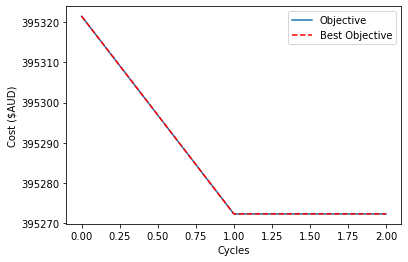

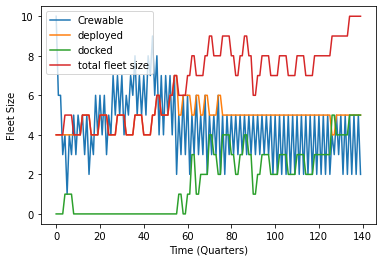

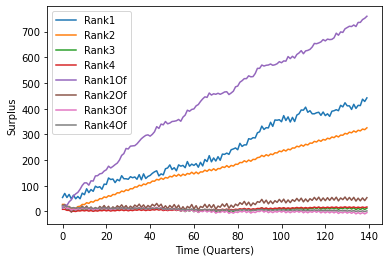

In [16]:
#Record and Plot results of Optimisation 
import os

filename="MixedRECOutput"
i = 0
while True:
    i += 1
    newname = '{}{:d}.txt'.format(filename, i)
    if os.path.exists(newname):
        continue
    with open(newname, "w") as text_file:
        print("Officer_max_rec: " + str(officer_max_rec)+ " Officer_min_rec: " + str(officer_min_rec)+" Sailor_max_rec: " + str(sailor_max_rec)+ " Sailor_min_rec: " + str(sailor_min_rec),file=text_file)
        print('Best solution (Officer / Sailor): ' + str(x_current)+'Best objective: ' + str(f_current),file=text_file)
        print("Cycles: "+ str(num_cycles) + " Trials: " + str(num_trials)+"Time: "+str(timeNow),file=text_file)
        break
filename="MixedRECCost"
fig = plt.figure()
rect = fig.patch
rect.set_facecolor("white")
plt.plot(f_stored, label="Objective")
plt.plot(fbest,'r--',label='Best Objective')
plt.legend()
plt.xlabel("Cycles")
plt.ylabel("Cost ($AUD)")
i = 0
while True:
    i += 1
    newname = '{}{:d}.png'.format(filename, i)
    if os.path.exists(newname):
        continue
    plt.savefig(newname)
    break
a,b,c,d,e,f,g,h,i1,j,k=policyOut(kronos,x_current, 0.1, 0.05)
 #a=crewable, b=deployed c=docked d=sailorR1 e=sailorR2 f=sailor2R3 g=sailorR4,
    #h=officerR1 i=officerR2 j=officerR3 k=officerR4
print(np.mean(c))
print((1-(np.mean(c)/(xt))))
fig1 = plt.figure()
rect = fig1.patch
rect.set_facecolor("white")
plt.plot(a, label="Crewable")
plt.plot(b,label='deployed')
plt.plot(c,label='docked')
plt.plot((np.add(b,c)),label='total fleet size')
plt.legend()
plt.xlabel("Time (Quarters)")
plt.ylabel("Fleet Size")
filename='MixedRECAvab'
i = 0
while True:
    i += 1
    newname = '{}{:d}.png'.format(filename, i)
    if os.path.exists(newname):
        continue
    plt.savefig(newname)
    break
#['Crewable','deployed','docked'])
fig2 = plt.figure()
rect = fig2.patch
rect.set_facecolor("white")
plt.plot(d,label='Rank1')
plt.plot(e,label='Rank2')
plt.plot(f,label='Rank3')
plt.plot(g,label='Rank4')
plt.plot(h,label='Rank1Of')
plt.plot(i1,label='Rank2Of')
plt.plot(j,label='Rank3Of')
plt.plot(k,label='Rank4Of')
plt.legend()
plt.xlabel("Time (Quarters)")
plt.ylabel("Surplus")
filename='MixedRECSurplus'
i = 0
while True:
    i += 1
    newname = '{}{:d}.png'.format(filename, i)
    if os.path.exists(newname):
        continue
    plt.savefig(newname)
    break
   
    

